In [4]:
!pip install torchvision
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 12.9 MB/s eta 0:00:00a 0:00:01


In [5]:
# Handling Model
import copy
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision import models as models
import torchvision.transforms.functional as F
from torchmetrics import Dice
import matplotlib.pyplot as plt
import os
from PIL import Image

Dataset

In [6]:

class BUIDSegmentationDataset(Dataset):
    def __init__(self, root_dir, size=256, augment=False):
        self.root_dir = root_dir
        self.size = size
        self.augment = augment
        self.image_files = []
        self.mask_files = []

        for subfolder in os.listdir(root_dir):
            subfolder_path = os.path.join(root_dir, subfolder)
            if os.path.isdir(subfolder_path):
                for file_name in os.listdir(subfolder_path):
                    if file_name.endswith('.png') and '_mask' not in file_name:
                        image_file = os.path.join(subfolder_path, file_name)
                        mask_file = os.path.join(subfolder_path, file_name.replace('.png', '_mask.png'))
                        if os.path.exists(mask_file):
                            self.image_files.append(image_file)
                            self.mask_files.append(mask_file)

        self.transform = transforms.Compose([
            transforms.Resize((self.size, self.size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
        ])
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert('RGB')
        mask = Image.open(self.mask_files[idx]).convert('L')
        
        if self.augment:
            image = self.augmentation(image)
            mask = self.augmentation(mask)
        
        image = self.transform(image)
        mask = transforms.Resize((self.size, self.size))(mask)
        mask = transforms.ToTensor()(mask)
        
        return image, mask

root_dir = './BUID'
size = 256

# Create the dataset
dataset = BUIDSegmentationDataset(root_dir, size)
augmented_dataset = BUIDSegmentationDataset(root_dir, size, augment=True)


In [7]:
def splitDataset(augmented_dataset):
    # Split dataset into a test and train datasets
    subsets = []

    # Get a size of fifth of dataset
    test_split = (int)(len(augmented_dataset) / 5)

    # Split fifth of dataset into test dataset
    remaining = len(augmented_dataset) - test_split
    test_dataset, remaining_dataset  = torch.utils.data.random_split(augmented_dataset, [test_split, remaining])

    # Get size of 1/10 of dataset
    split = (int)(len(augmented_dataset) / 10)

    # Split the remaining into 1/10 of original dataset, for training set
    while remaining >= split:
        remaining = len(remaining_dataset) - split
        split_dataset, remaining_dataset  = torch.utils.data.random_split(remaining_dataset, [split, remaining])
        subsets.append(split_dataset)
        
    return subsets, test_dataset

In [10]:
dataset.__len__()

780

Training Method

In [8]:
# Define the training function
def train_fn(model, loss_fn, dataloader, optimizer, device = 'cpu'):
    
    model.train()

    avg_loss = 0
    for i, (X, y) in enumerate(dataloader):
        # Get data
        X_train, y_train = X.to(device), y.to(device)  
        # Get Output
        output = model(X_train).to(device)
        # Compute loss
        loss = loss_fn(output, y_train)
        avg_loss += loss.item()
        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return avg_loss / len(dataloader)
    
        

Test Method

In [9]:
def test_fn(model, loss_fn, dice, dataloader, device = 'cpu'):
    model.eval()
    test_loss = 0
    test_dice = 0
    with torch.inference_mode():
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = loss_fn(output, y)
            test_loss += loss.item()
            test_dice += dice(torch.where(output > 0.5, 1, 0),torch.where(y > 0.50, 1, 0)).item()

    
    test_loss /= len(dataloader)
    test_dice /= len(dataloader)
    
    return test_loss, test_dice

Save Model Method

In [115]:
def saveModel(model, name):
    # Directory Name
    directory = './models/'
    # Create models folder and checks if it exists
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory {directory} created successfully...")
    # Define path and name
    path = os.path.join(directory, name)
    # Save model
    torch.save(model, path)
    print(f"{name} saved succesfully")

Training

In [116]:
splits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

BATCH_SIZE = 128
num_workers = 0

device = 'cuda' if torch.cuda.is_available() else 'cpu'

lr = 0.01
loss_fn = torch.nn.BCELoss()


dice = Dice(average = 'micro', num_classes = 2, threshold = 0.5).to(device)

In [117]:
SPLIT_TEST_DICE = [0,0,0,0,0,0,0,0]
SPLIT_TEST_LOSS = [0,0,0,0,0,0,0,0]

# Number of times to run experiment
iterations = 4

# Threshold loss to stop training model
threshold_loss = 0.3

# Run experiment multiple times
for j in range(iterations):
    # Get test dataset and train splits
    subsets, test_dataset = splitDataset(augmented_dataset)
    for i in range(len(subsets)):
        # Initialize model, optimizer, and learning rate scheduler
        model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=64, pretrained=False, trust_repo=True).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr)
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
        #name = f'UNet|Split:{(i+1)/10}|Iter:{j}'
        
        # Create train dataset for split
        train_dataset = torch.utils.data.ConcatDataset(subsets[:i+1])
        
        # Load datasets into dataloaders
        if i == 0: # Error when loading single dataset in concat into loader, so seperate case
            train_dataloader = torch.utils.data.DataLoader(dataset=subsets[i], num_workers = num_workers, shuffle =True)
        else:
            train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, num_workers = num_workers, shuffle =True)
        test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, num_workers = num_workers, shuffle =False)
        
        # Initialize loss and previous loss
        loss = float("inf")
        best_loss = float("inf")
        # Train model until it reaches threshold loss
        while(loss > threshold_loss):
            
            # Compute training loss
            loss = train_fn(model, loss_fn, train_dataloader, optimizer, device)
            # Update best loss if new loss is less than it
            if best_loss > loss:
                best_loss = loss
            # Adjust learning rate if new loss is worse than best loss
            else:
                lr_scheduler.step()
        # Check accuracy and loss on test set
        test_loss , test_dice = test_fn(copy.deepcopy(model), loss_fn, dice, test_dataloader, device)
        # Save model
        #saveModel(model,name)
        # Save test loss and dice score for plotting later
        SPLIT_TEST_DICE[i] += test_dice
        SPLIT_TEST_LOSS[i] += test_loss
# Take average of experiments
for i in range(len(subsets)):
    SPLIT_TEST_DICE[i] /= iterations
    SPLIT_TEST_LOSS[i] /= iterations
    

Using cache found in C:\Users\Sebastian/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
Using cache found in C:\Users\Sebastian/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
Using cache found in C:\Users\Sebastian/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
Using cache found in C:\Users\Sebastian/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
Using cache found in C:\Users\Sebastian/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
Using cache found in C:\Users\Sebastian/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
Using cache found in C:\Users\Sebastian/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
Using cache found in C:\Users\Sebastian/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
Using cache found in C:\Users\Sebastian/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
Using cache found in C:\Users\Sebastian/.cache\torch\hub\mateuszbuda_brai

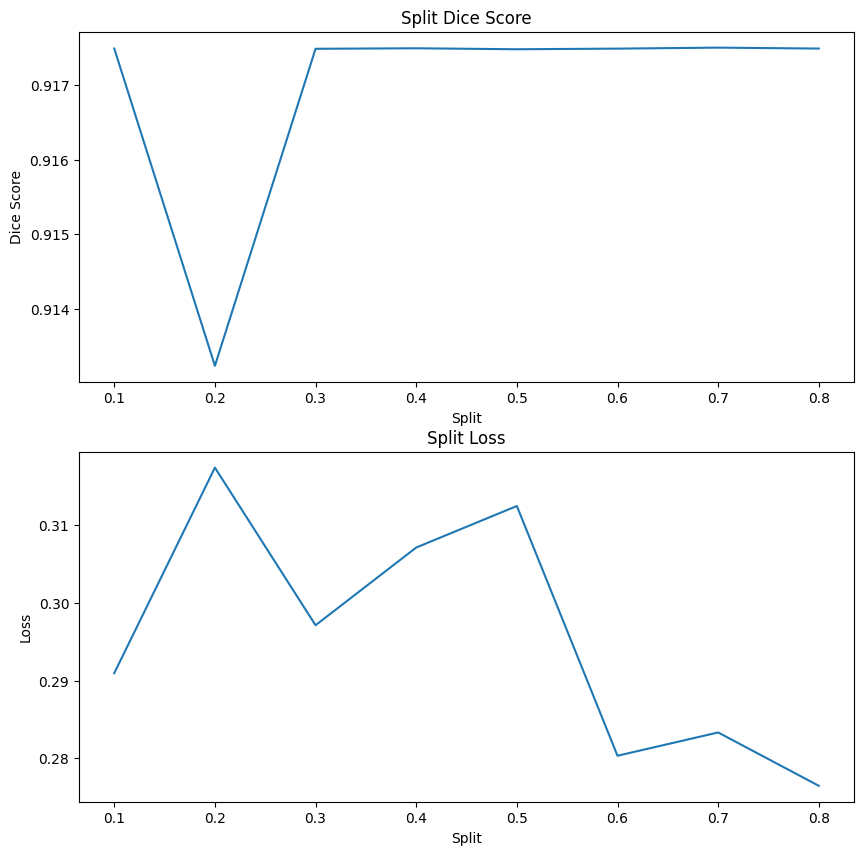

<Figure size 640x480 with 0 Axes>

In [118]:
# Plot test loss and dice
splits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,]

fig, ax = plt.subplots(2,1, figsize=(10,10))
plt.figure()
# Plot dice scores
ax[0].plot(SPLIT_TEST_DICE, label = "Split Dice Score")
ax[0].set_title("Split Dice Score")
ax[0].set_xlabel("Split")
ax[0].set_ylabel("Dice Score")
ax[0].set_xticks(range(len(splits)))
ax[0].set_xticklabels(splits)
# Plot losses
ax[1].plot(SPLIT_TEST_LOSS, label = "Split Loss")
ax[1].set_title("Split Loss")
ax[1].set_xlabel("Split")
ax[1].set_ylabel("Loss")
ax[1].set_xticks(range(len(splits)))
ax[1].set_xticklabels(splits)

plt.show()